(groups_comparison_notebook)=
# Confronto tra gruppi

L'obiettivo di questo capitolo è di ampliare la discussione del capitolo {ref}`bayes_one_mean_notebook`, affrontando il confronto tra le medie di due o più gruppi indipendenti.  Per cominciare, carichiamo le librerie necessarie.

In [4]:
from pymc import HalfNormal, HalfCauchy, Model, Normal, sample
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


In [5]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set(color_codes=True)

## Stima della media di un gruppo

Partiamo dal caso già discusso nel capitolo precedente, in cui abbiamo stimato l'incertezza relativa alla media di un singolo gruppo. Qui faremo uso dei dati relativi ai pinguini Palmer, che andremo a leggere da un file csv, escludendo quelli mancanti:

In [6]:
penguins = pd.read_csv("data/penguins.csv")
# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = penguins.loc[~missing_data]
penguins.shape


(333, 8)

Otteniamo in questo modo un DataFrame con 333 righe e 8 colonne. Calcoliamo la media del peso `body_mass_g` in funzione della specie:

In [7]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean", "std", "count"])
)
summary_stats.round(1)


body_mass_g             
                 mean    std count
species                           
Adelie         3706.2  458.6   146
Chinstrap      3733.1  384.3    68
Gentoo         5092.4  501.5   119

Otteniamo un grafico a violino per questi dati.

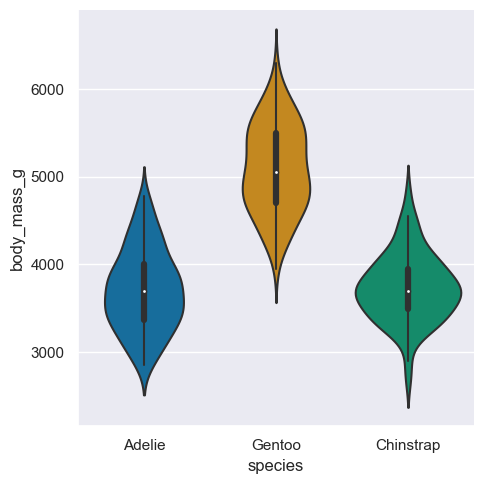

In [6]:
sns.catplot(kind="violin", data=penguins, x="species", y="body_mass_g")
plt.show()


Le descrizioni precedenti riguardano i dati del campione. In un altro campione i valori saranno diversi. Poniamoci dunque il problema di quantificare l'intertezza che abbiamo relativamente alla stima del peso delle tre specie di pinguini, sapendo che la stima attuale si basa solo su un piccolo campione di osservazioni.

Un modo per quantificare l'incertezza della nostra stima è quello di utilizzare i metodi bayesiani. 

Per fare questo abbiamo bisogno di fare riferimento ad un modello statistico tramite il quale sia possibile descrive la relazione tra osservazioni e parametri. Per il caso presente, descriviamo la distribuzione a posteriori dei parametri, alla luce dei dati, nel modo seguente:

$$
p(\mu, \sigma \mid y) \propto p(y \mid \mu, \sigma) p(\mu)p(\sigma),
$$

laddove per la verosimilianza useremo una densità Normale. La Normale dipende da due parametri, $\mu$ e $\sigma$. Abbiamo dunque bisogno di specificare le distribuzioni a priori di questi due parametri. Per $\mu$ useremo una distribuzione Normale: $\mu \sim \mathcal{N}(4000, 2000)$; per $\sigma$ useremo una Normale troncata (valori negativi sono impossibili): $\sigma \sim \mathcal{HN}(2000)$.

Iniziamo questo esempio selezionando unicamente i pinguini della specie Adelie. Per queste osservazioni, i valori della variabile `body_mass_g` sono i seguenti:

In [11]:
adelie_mass_obs = penguins[penguins["species"] == "Adelie"]["body_mass_g"]
print(adelie_mass_obs)


0      3750.0
1      3800.0
2      3250.0
4      3450.0
5      3650.0
        ...  
147    3475.0
148    3450.0
149    3750.0
150    3700.0
151    4000.0
Name: body_mass_g, Length: 146, dtype: float64


Implementiamo il modello descritto in precedenza usando PyMC. 

Prima di effettuare il campionamento della distribuzione a posteriori esaminiamo la distribuzione predittiva a priori per verificare l'adeguatezza della assunzioni relative alle distribuzioni a priori dei parametri. Per questo scopo, usiamo la funzione `pm.sample_prior_predictive()`. Generiamo 1000 valori casuli dalle distribuzioni a priori dei due parametri.

In [20]:
with pm.Model() as model_adelie_penguin_mass:
    sigma = pm.HalfNormal("sigma", sigma=1000)
    mu = pm.Normal("mu", 4000, 2000)
    mass = pm.Normal("mass", mu=mu, sigma=sigma, observed=adelie_mass_obs)

    idata1 = pm.sample_prior_predictive(samples=1000, random_seed=rng)


Sampling: [mass, mu, sigma]


Dall'oggetto inferenceData `idata1` recuperiamo i campioni delle distribuzioni a priori e li passiamo a `az.plot_trace()`:

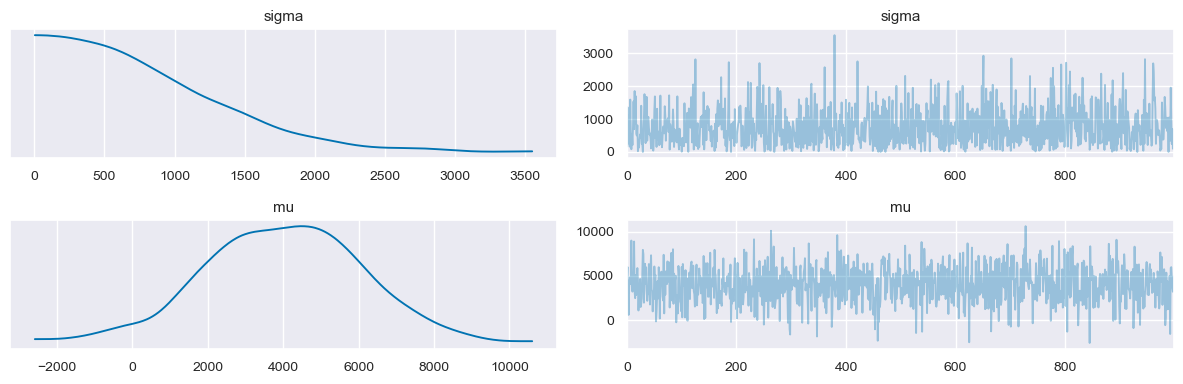

In [21]:
prior = idata1.prior
_ = az.plot_trace(prior)
plt.tight_layout()


Dall'esame delle distribuzioni a priori dei due parameti è evidente che non stiamo vincolando eccessivamente il campionamento della variabile `adelie_mass_obs`. Potremmo anzi avere scelto delle distribuzioni a priori troppo larghe, considerato che la distribuzione a priori per $\mu$ include anche valori negativi. Tuttavia, poiché questo è un modello semplice e abbiamo un discreto numero di osservazioni, non dobbiamo preoccuparci.  Passiamo dunque alla stima della distribuzione a posteriori.

In [22]:
with pm.Model() as model_adelie_penguin_mass:
    sigma = pm.HalfNormal("sigma", sigma=1000)
    mu = pm.Normal("mu", 4000, 2000)
    mass = pm.Normal("mass", mu=mu, sigma=sigma, observed=adelie_mass_obs)

    idata2 = pm.sample(3000, chains=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 25 seconds.


Il KDE ploy e il rank plot della distribuzione a posteriori dei parametri del modello bayesiano servono come strumenti diagnostici visivi per aiutarci a capire se ci sono stati problemi durante il campionamento. Non vi sono evidenze di alcun problema.

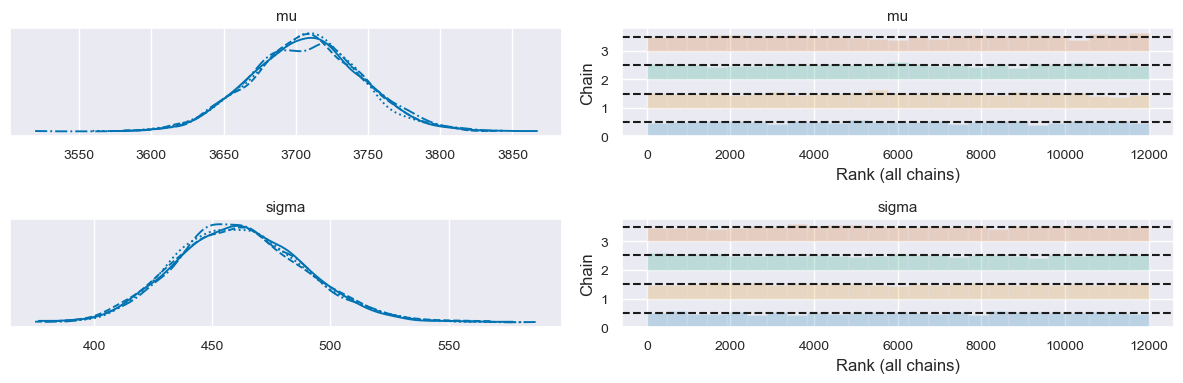

In [23]:
axes = az.plot_trace(idata2, divergences="bottom", kind="rank_bars")
plt.tight_layout()


Possiamo combinare le quattro catene. Un confronto tra la stima della distribuzione a posteriori e le stime puntuali dei due parametri che abbiamo ottenuto dal campione (linee verticali) è fornito nella figura seguente.

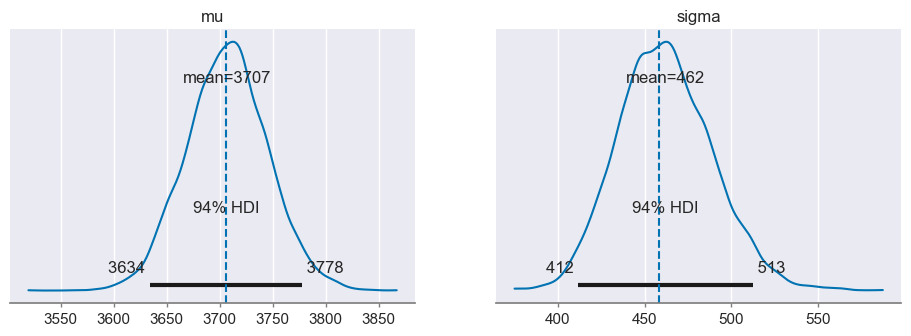

In [24]:
axes = az.plot_posterior(idata2, hdi_prob=0.94)

axes[0].axvline(3706.2, linestyle="--")
axes[1].axvline(458.6, linestyle="--")


Con la stima bayesiana otteniamo una distribuzione dei valori credibili dei parametri. Nelle distribuzioni a posteriori che abbiamo ottenuto per $\mu$ e $\sigma$, le stime campionarie rappresentano il valore più credibile, ma abbiamo imparato qual è la gamma di valori all'interno della quale ci possiamo aspettare che si trovi il "vero" valore del parametro (se venissero esaminati campioni diversi di osservazioni). L'intervallo di valori plausibili è piuttosto stretto per il parametro $\mu$ (diciamo, tra 3634 a 3778) ed anche per $\sigma$ (94% HDI: [412, 513]). 

Le due distribuzioni a posteriori descrivono l'incertezza che abbiamo relativamente ai veri valori di $\mu$ e $\sigma$, considerate le nostre credenze precedenti (che in questo caso corrispondevano a delle distribuzioni a priori debolmente informative, con l'unico scopo di regolarizzare i dati), i dati osservati e l'ipotesi che abbiamo fatto sul *meccanismo generatore dei dati*.

Un sommario numerico viene ottenuto con le seguenti istruzioni:

In [25]:
az.summary(idata2).round(2)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,3707.08,38.32,3634.13,3777.66,0.35,0.25,12042.0,8331.0,1.0
sigma,461.91,27.28,411.65,512.70,0.25,0.18,11681.0,8298.0,1.0


## Confronto tra più gruppi

Il confronto tra più gruppi richiede di eseguire la stessa procedura di campionamento che abbiamo descritto sopra separatamente per diversi gruppi di osservazioni. Si tratta dunque di trovare un modo per comunicare a PyMC di fare questo.

Per capire la procedura da seguire dobbiamo prima capire come sono organizzati i dati in un oggetto di classe `inferenceData`.

## Coordinate in PyMC e negli oggetti InferenceData

I risultati dell'analisi a posteriori ottenuti tramite PyMC vengono immagazzinati in un oggetto di tipo `inferenceData`. A volte, per analizzare questi dati, è necessario estrarli dall'oggetto `inferenceData`. Per chiarire come questo possa essere fatto, in questo capitolo analizzeremo con maggior dettaglio le proprietà dell'oggetto `inferenceData`.

L'oggetto `inferenceData` di ArviZ è in realtà un oggetto di tipo `Dataset` di `xarray`. `xarray` è una libreria che generalizza sia gli array di Numpy che i dataframe di Pandas. Vediamo come sono fatti gli oggetti di `xarray`. Di seguito è mostrato un esempio di un array standard di Numpy.

In [ ]:
npdata = rng.standard_normal(size=(2, 3))
npdata

array([[ 0.30471708, -1.03998411,  0.7504512 ],
       [ 0.94056472, -1.95103519, -1.30217951]])

Useremo questo array di Numpy per creare un oggetto `DataArray` di `xarray`.

In [ ]:
data = xr.DataArray(
    npdata,
    dims=("user", "day"),
    coords={"user": ["Alice", "Bob"], "day": ["yesterday", "today", "tomorrow"]},
)
data


<xarray.DataArray (user: 2, day: 3)>
array([[ 0.30471708, -1.03998411,  0.7504512 ],
       [ 0.94056472, -1.95103519, -1.30217951]])
Coordinates:
  * user     (user) <U5 'Alice' 'Bob'
  * day      (day) <U9 'yesterday' 'today' 'tomorrow'

Come si può vedere, i dati non sono cambiati, ma ora sono accompagnati da informazioni aggiuntive. La terminologia è la seguente. Il nostro oggetto `xarray` è di classe `DataArray`. L'array ha 2 dimensioni: una chiamata "user" e l'altra chiamata "day".

In [ ]:
data.dims

('user', 'day')

Ogni dimensione ha diverse coordinate. La dimensione "user" include le coordinate "Alice" o "Bob". La dimensione "day" include le coordinate yesterday', 'today', 'tomorrow'.

In [ ]:
data.coords

Coordinates:
  * user     (user) <U5 'Alice' 'Bob'
  * day      (day) <U9 'yesterday' 'today' 'tomorrow'

Queste coordinate possono essere utilizzate al posto degli indici numerici standard. Per esempio, possiamo selezioniamo il valore corrispondente a "Alice" e "yesterday" dall'array di Numpy nel modo seguente.

In [ ]:
npdata[0,0]

0.30471707975443135

Facciamo di nuovo la stessa operazione usando questa volta l'oggetto `DataArray` di `xarray`.

In [ ]:
data.sel(user="Alice", day="yesterday")

<xarray.DataArray ()>
array(0.30471708)
Coordinates:
    user     <U5 'Alice'
    day      <U9 'yesterday'

Quindi, uno dei vantaggi degli oggetti `xarray` è la presenza di coordinate etichettate semanticamente. Non è più necessario ricordare che `npdata[:,0]` corrisponde a "yesterday" e `npdata[1,:]` corrisponde a "Bob". Inoltre, non è nemmeno necessario ricordare l'ordine degli assi. L'ordine in cui le dimensioni sono memorizzate è irrilevante perché usiamo le etichette delle dimensioni (anche se l'indicizzazione numerica rimane possibile).

In [ ]:
data.sel(day="yesterday", user="Alice")

<xarray.DataArray ()>
array(0.30471708)
Coordinates:
    user     <U5 'Alice'
    day      <U9 'yesterday'

In [ ]:
data.sel(user="Alice", day="yesterday")

<xarray.DataArray ()>
array(0.30471708)
Coordinates:
    user     <U5 'Alice'
    day      <U9 'yesterday'

Infine, `xarray` consente anche la creazione di oggetti che includono più oggetti `DataArray`. `xarray` chiama tale oggetto un `Dataset`. Fondamentalmente, è ciò con cui abbiamo a che fare quando otteniamo un oggetto `inferenceData` di ArviZ dopo il campionamento.

In [ ]:
var2 = xr.DataArray(
    rng.standard_normal(size=(2, 2)),
    dims=("x", "y"),
    coords={"x": [0, 1], "y": [11, 42]},
)
var3 = xr.DataArray(
    rng.standard_normal(size=(2, 2)),
    dims=("a", "b"),
    coords={"a": [4.2, 11.8], "b": ["Geneva", "London"]},
)
ds = xr.Dataset(dict(orig=data, v2=var2, v3=var3))
ds


<xarray.Dataset>
Dimensions:  (user: 2, day: 3, x: 2, y: 2, a: 2, b: 2)
Coordinates:
  * user     (user) <U5 'Alice' 'Bob'
  * day      (day) <U9 'yesterday' 'today' 'tomorrow'
  * x        (x) int64 0 1
  * y        (y) int64 11 42
  * a        (a) float64 4.2 11.8
  * b        (b) <U6 'Geneva' 'London'
Data variables:
    orig     (user, day) float64 0.3047 -1.04 0.7505 0.9406 -1.951 -1.302
    v2       (x, y) float64 0.1278 -0.3162 -0.0168 -0.853
    v3       (a, b) float64 0.8794 0.7778 0.06603 1.127

Si noti che ci sono 6 dimensioni (user, day, x, y, a, b), ma ciascuna variabile nel Dataset ne usa solo 2.

Per accedere a ogni singola variabile, possiamo utilizzare l'indicizzazione dei dizionari:

In [ ]:
ds["orig"]


<xarray.DataArray 'orig' (user: 2, day: 3)>
array([[ 0.30471708, -1.03998411,  0.7504512 ],
       [ 0.94056472, -1.95103519, -1.30217951]])
Coordinates:
  * user     (user) <U5 'Alice' 'Bob'
  * day      (day) <U9 'yesterday' 'today' 'tomorrow'

In [ ]:
ds["orig"].sel(user="Alice")

<xarray.DataArray 'orig' (day: 3)>
array([ 0.30471708, -1.03998411,  0.7504512 ])
Coordinates:
    user     <U5 'Alice'
  * day      (day) <U9 'yesterday' 'today' 'tomorrow'

In [ ]:
ds["orig"].sel(user="Alice", day="yesterday")

<xarray.DataArray 'orig' ()>
array(0.30471708)
Coordinates:
    user     <U5 'Alice'
    day      <U9 'yesterday'

## Confonto tra più gruppi

Esaminiamo ora un esempio che ci consentirà di applicare le nozioni discusse in precedenza per forzare il campionamento a venire eseguito separatamente tra diversi gruppi di osservazioni. Ciò ci consentirà di eseguire l'inferenza relativa alle differenze tra le medie dei gruppi.

Poiché abbiamo bisogno di indicare l'appartenenza al gruppo mediante degli indici numerici, usiamo `pd.factorize` per creare dei valori numerici  (0, 1, 2) che distinguono tra i tre gruppi. Chiamiamo questo indice `species_idx`.

In [9]:
species_idx, species_codes = pd.factorize(penguins["species"])
print(species_idx)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


Il valore 0 identifica la specie Amelie, il valore 1 identifica la specie Gentoo e il valore 2 la specie Chinstrap.

In [50]:
print(*penguins["species"])

Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie Adelie

Scriviamo ora il modellp per il campionamento MCMC. Si noti che la specificazione del modello è quasi identica a quella che abbiamo usato nel caso di un solo gruppo. La differenza è che ora aggiungiamo la richiesta che il campionamento venga fatto separatamente per i tre gruppi di osservazioni. A questo fine abbiamo aggiunto l'argomento `dims = "species"` nella specificazione delle distribuzioni a priori. Inoltre, nella verosimiglianza abbiamo specificato `mu_prior[species_idx]` e `sigma_prior[species_idx]` in modo da indicare che le osservazioni appartengono a 3 gruppi diversi, così come specificato dalla variabile `species`. Si noti inoltre che abbiamo passato a `pm.Model()` il dizionario `coords` dove la chiave `species` è associata ad una lista di interi `[0, 1, 2]`.

In [16]:
coords = {"species": [0, 1, 2]}

with pm.Model(coords=coords) as labeled_model:
    mu_prior = pm.Normal("mu", mu=4000, sigma=500, dims="species")
    sigma_prior = pm.HalfCauchy("sigma", beta=1000, dims="species")
    likelihood = pm.Normal(
        "likelihood",
        mu=mu_prior[species_idx],
        sigma=sigma_prior[species_idx],
        observed=penguins["body_mass_g"],
    )

Eseguiamo il campionamento.

In [17]:
with labeled_model:
    labeled_idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


Esaminiamo le distribuzioni a posteriori e le diagnostiche del campionamento.

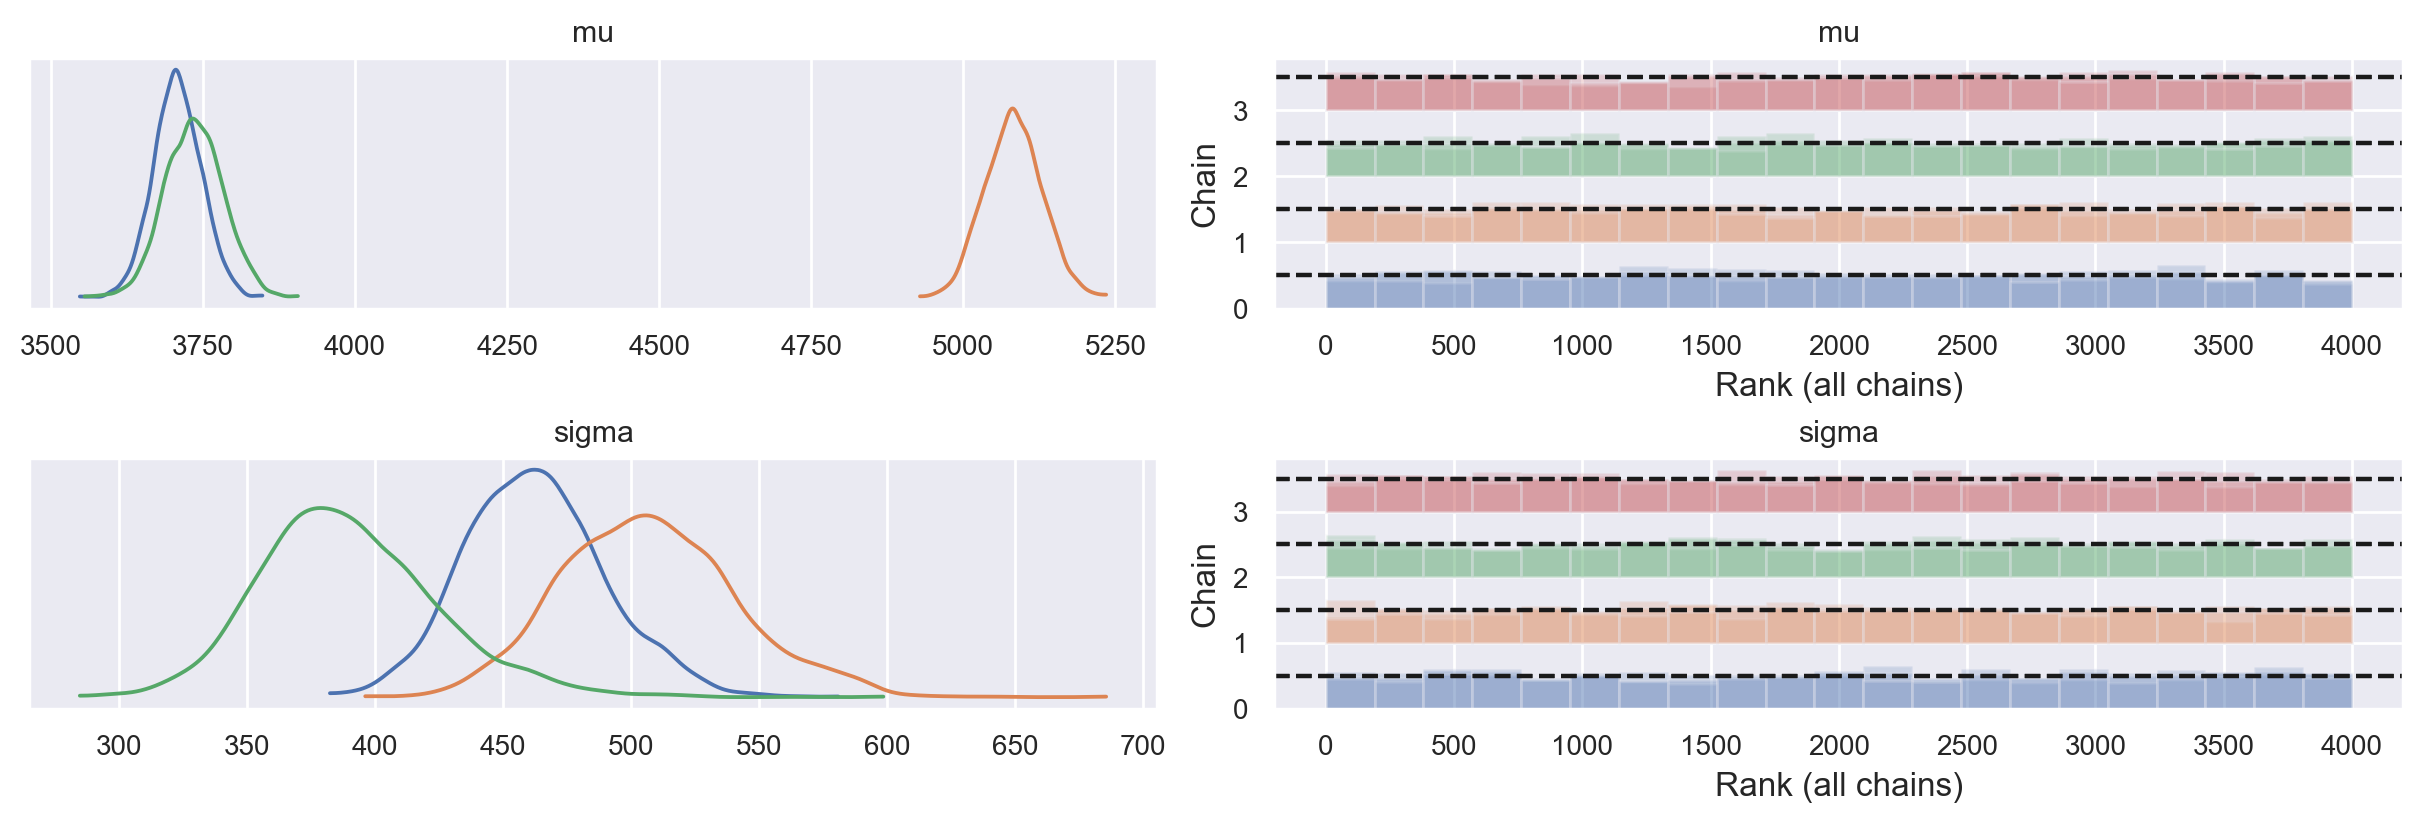

In [18]:
axes = az.plot_trace(
    labeled_idata, combined=True, divergences="bottom", kind="rank_bars"
)
plt.tight_layout()


Abbiamo ottenuto tre distribuzioni a posteriori per ciascuno dei due parametri $\mu$ e $\sigma$, una distribuzione per ciascuna specie di pinguini.

Esaminiamo se le quattro catene hanno prodotto risultati diversi per il parametro $\mu$.

Text(0.5, 1.0, 'μ Mass Estimate: 94.0% HDI')

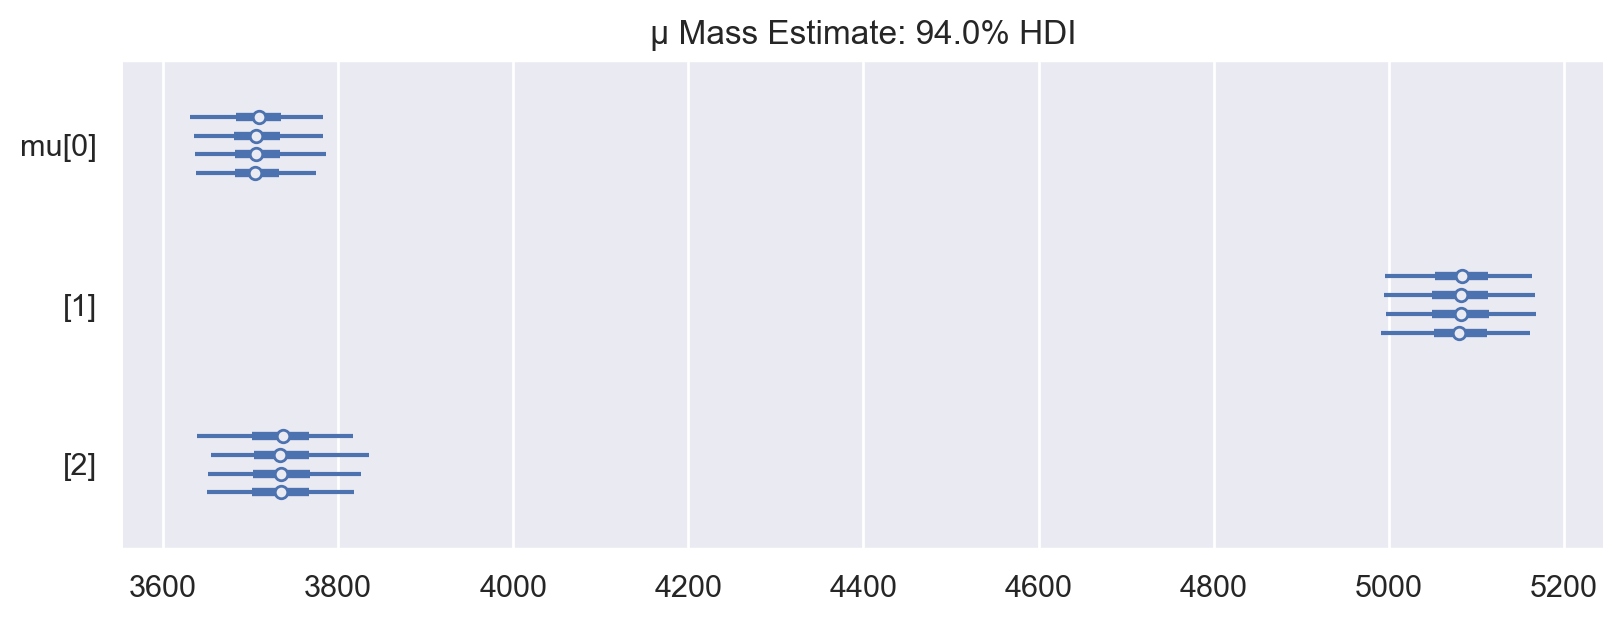

In [20]:
axes = az.plot_forest(labeled_idata, var_names=["mu"], figsize=(8, 3))
axes[0].set_title("μ Mass Estimate: 94.0% HDI")


Facciamo la stessa cosa per il parametro $\sigma$.

Text(0.5, 1.0, 'σ Mass Estimate: 94.0% HDI')

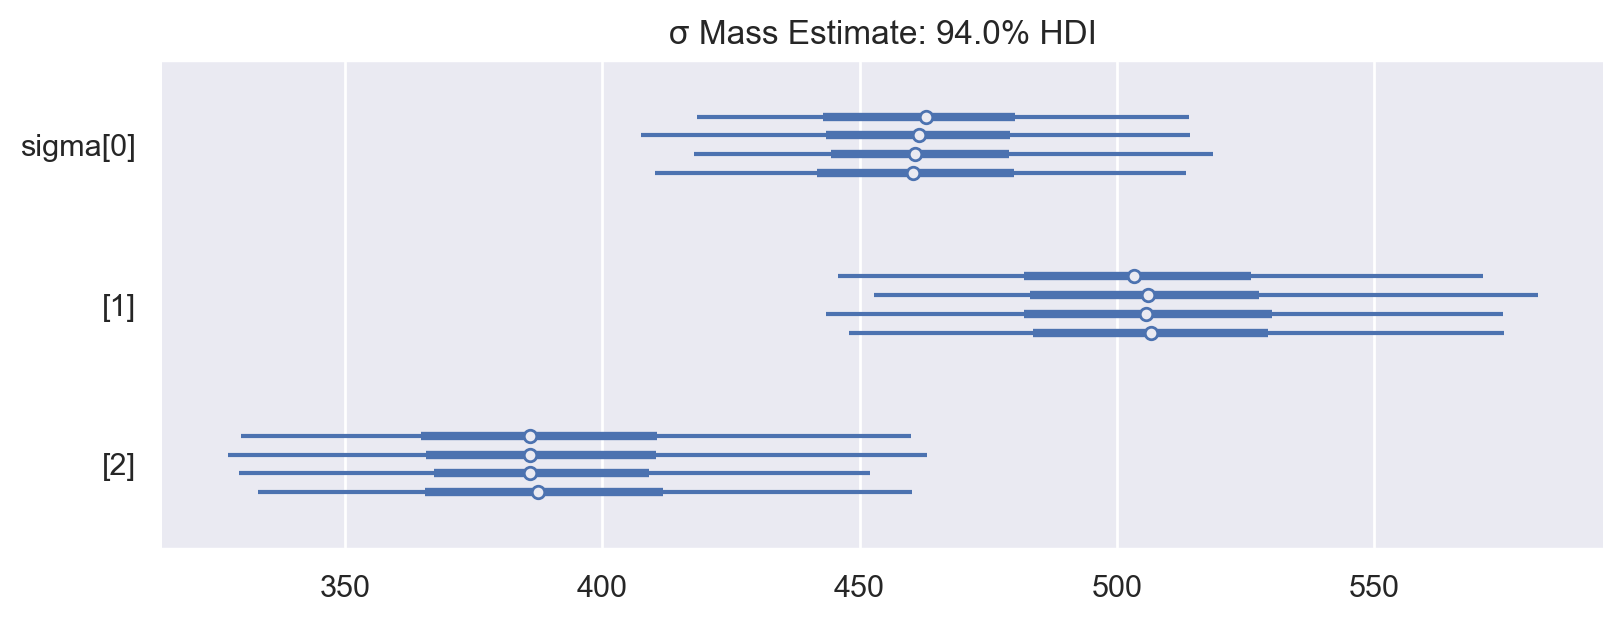

In [21]:
axes = az.plot_forest(labeled_idata, var_names=["sigma"], figsize=(8, 3))
axes[0].set_title("σ Mass Estimate: 94.0% HDI")


Un sommario numerico delle distribuzioni a posteriori si ottiene nel modo seguente.

In [53]:
az.summary(labeled_idata, kind="stats").round(2)


,mean,sd,hdi_3%,hdi_97%
mu[0],3707.76,39.09,3638.18,3785.88
mu[1],5082.59,46.52,4995.92,5167.49
mu[2],3735.46,47.57,3650.08,3826.64
sigma[0],462.35,27.34,411.83,515.57
sigma[1],506.68,34.01,443.73,573.22
sigma[2],389.55,34.70,330.09,460.29


Possiamo dedurre dall'analisi delle distribuzioni a posteriori o degli intervalli di credibilità che il peso dei pinguini Adelie e Chinstrap è simile, mentre i pinguini Gentoo sono generalmente più pesanti. Inoltre, l'analisi indica una maggiore variabilità nel peso dei pinguini Gentoo, seguita da quella dei pinguini Adelie. Al contrario, i pinguini Chinstrap mostrano una maggiore omogeneità nel peso.

## Verifica di ipotesi bayesiana

Una volta ottenuto un campione della distribuzione a priori del parametro di interesse $\mu$ per ciascuna delle tre specie di pinguini, possiamo chiederci quale sia la probabilità che il peso di un pinguino di una specie sia maggiore di quello di un pinguino di un'altra specie. Possiamo rispondere a questa domanda utilizzando un campione casuale della distribuzione a posteriori. Per fare ciò, dobbiamo confrontare il parametro di interesse per molti valori e calcolare la media dei valori trovati.

Per recuperare i valori numerici della distribuzione a posteriori del parametro $\mu$ dall'oggetto `labeled_idata`, possiamo utilizzare le funzioni di `ArviZ`.

Esaminiamo le proprietà dell'oggetto `labeled_idata`.

In [34]:
labeled_idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Recuperiamo i valori a posteriori del parametro $\mu$.

In [38]:
mu_post = labeled_idata.posterior['mu']

L'oggett ottenuto è un array di dimensioni $4 \times 1000 \times 3$. L'indice 4 si riferisce alle catente, l'indice 1000 si riferisce al numero di campioni ottenuti, l'indice 3 si riferisce ai gruppi. 

In [39]:
mu_post.shape

(4, 1000, 3)

Per trovare la media a posteriori del parametro $\mu$ della specie Adelie prendiamo le osservazioni che si riferiscono a tutte le catene (:), a tutti i valori campionati (:) per il primo gruppo (0). La media a posteriori dei pinguini Adelie è dunque uguale a

In [40]:
print(mu_post[:, :, 0].mean())

<xarray.DataArray 'mu' ()>
array(3707.7566205)
Coordinates:
    species  int64 0


Per tutte e tre le specie (Adelie, Gentoo, Chinstrap) abbiamo

In [43]:
np.array(
    [mu_post[:, :, 0].mean(), mu_post[:, :, 1].mean(), mu_post[:, :, 2].mean()]
).round(1)


array([3707.8, 5082.6, 3735.5])

In [42]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean", "std", "count"])
)
summary_stats.round(1)

body_mass_g             
                 mean    std count
species                           
Adelie         3706.2  458.6   146
Chinstrap      3733.1  384.3    68
Gentoo         5092.4  501.5   119

Per verificare che l'ordinamento dei gruppi corrisponda a Adelie, Gentoo, Chinstrap, esaminiamo la stima a posteriori della deviazione standard delle tre specie. 

In [45]:
sigma_post = labeled_idata.posterior["sigma"]
np.array(
    [sigma_post[:, :, 0].mean(), sigma_post[:, :, 1].mean(), sigma_post[:, :, 2].mean()]
).round(1)


array([462.4, 506.7, 389.6])

I valori trovati confermano quello che ci aspettavamo. Ora che abbiamo capito come estrarre le stime a posteriori di un parametro per ciascun gruppo, possiamo passare al test di ipotesi bayesiano.
Chiediamoci quale sia la probabilità che un pinguino Adelie abbia un peso minore di un pinguino Chinstrap.

In [46]:
np.mean([mu_post[:, :, 0] < mu_post[:, :, 2]])

0.664

Chiediamoci quale sia la probabilità che un pinguino Adelie abbia un peso minore di un pinguino Gentoo.

In [30]:
np.mean([mu_post[:, :, 0] < mu_post[:, :, 2]])

0.664

Chiediamoci quale sia la probabilità che un pinguino Adelie abbia un peso minore di un pinguino Gentoo.

In [47]:
np.mean([mu_post[:, :, 0] < mu_post[:, :, 1]])

1.0

Consideriamo ora le deviazioni standard. Troviamo la probabilità che la varianza del peso dei pinguini Adelie sia minore di quella dei pinguini Chinstrap.

In [48]:
np.mean([sigma_post[:, :, 2] > sigma_post[:, :, 0]])

0.049

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor